In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import plotly.express as px
import plotly.io as pio
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sqlalchemy import create_engine
import logging
import os
from dotenv import load_dotenv

load_dotenv()
db_url = os.getenv("DATABASE_URL")
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
pd.set_option("display.float_format", "{:.2f}".format)

/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Connect to your Postgres database
engine = create_engine(db_url)

# Load the table into a DataFrame
df = pd.read_sql("SELECT * FROM houston_311", engine)

pio.renderers.default = "notebook_connected"

In [3]:
df.describe

<bound method NDFrame.describe of                CASE NUMBER            NEIGHBORHOOD              DEPARTMENT  \
0               2400190762              BRAYS OAKS  Solid Waste Management   
1               2400190761  SOUTH BELT / ELLINGTON  Solid Waste Management   
2               2400190760         GREATER HEIGHTS  Solid Waste Management   
3               2400190759            EAST HOUSTON  Solid Waste Management   
4               2400190758                LANGWOOD  Solid Waste Management   
...                    ...                     ...                     ...   
3472958  286595-2400190767     NORTHSIDE/NORTHLINE           Neighborhoods   
3472959  286596-2400190766             SECOND WARD           Neighborhoods   
3472960         2400190765       CENTRAL SOUTHWEST  Solid Waste Management   
3472961         2400190764               SETTEGAST  Solid Waste Management   
3472962         2400190763              SOUTH PARK  Solid Waste Management   

               DIVISION      

In [4]:
df.dtypes

CASE NUMBER                     object
NEIGHBORHOOD                    object
DEPARTMENT                      object
DIVISION                        object
CASE TYPE                       object
CREATED DATE            datetime64[ns]
CLOSED DATE             datetime64[ns]
LATITUDE                       float64
LONGITUDE                      float64
CATEGORY                        object
RESOLUTION_TIME_DAYS           float64
dtype: object

In [5]:
df[df["CREATED DATE"] > pd.Timestamp.today()]

,CASE NUMBER,NEIGHBORHOOD,DEPARTMENT,DIVISION,CASE TYPE,CREATED DATE,CLOSED DATE,LATITUDE,LONGITUDE,CATEGORY,RESOLUTION_TIME_DAYS


In [6]:
cols = ["NEIGHBORHOOD", "DEPARTMENT", "DIVISION", "CATEGORY", "CASE TYPE"]

for c in cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .str.title()
        .str.replace("\s+", " ", regex=True)
    )

In [7]:
# Aggregate by month
overall_ts = (
    df.groupby(pd.Grouper(key='CREATED DATE', freq='ME'))
      .size()
      .reset_index(name='y')
      .rename(columns={'CREATED DATE': 'ds'})
)

# Remove months with too few rows
cleaned_ts = overall_ts[overall_ts["y"] > 1000] 

# Determine the last fully complete month
last_month = cleaned_ts['ds'].max()
cleaned_ts = cleaned_ts[cleaned_ts['ds'] < last_month]

# Fit Prophet
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(cleaned_ts)

# Forecast next 12 months
future = m.make_future_dataframe(periods=12, freq='ME')
forecast = m.predict(future)

20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing


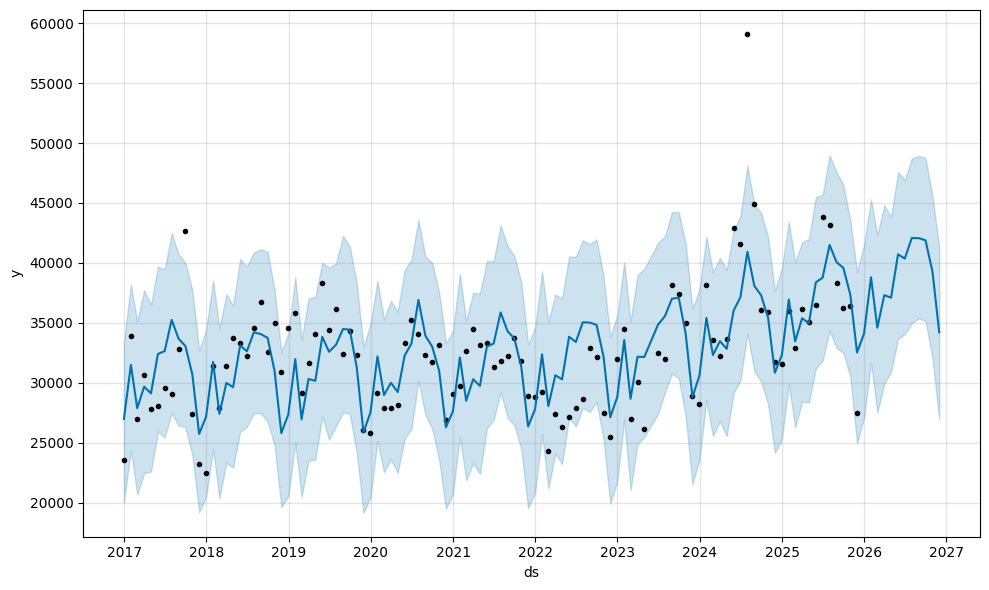

In [8]:
plot1 = m.plot(forecast)

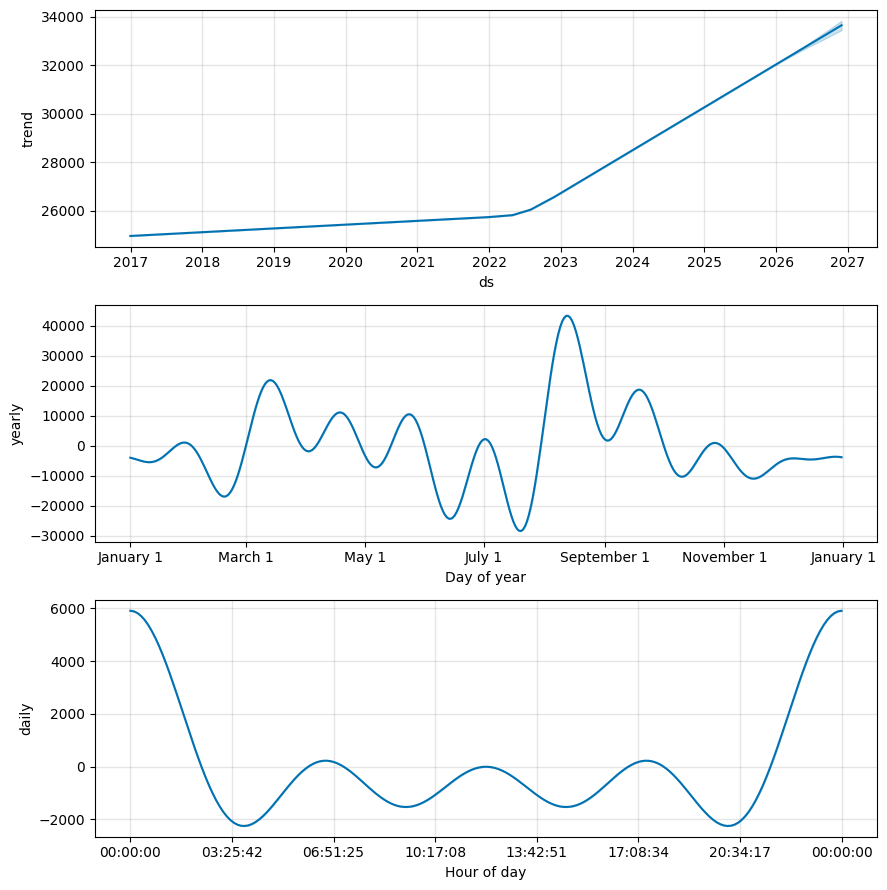

In [9]:
plot2 = m.plot_components(forecast)

In [10]:
# Merge forecasted values with actuals
results = cleaned_ts.merge(forecast, on='ds', how='left')

# Keep only training portion (historical)
historical = results[results['ds'] <= cleaned_ts['ds'].max()]

In [11]:
# Calculate error metrics
y_true = historical['y']
y_pred = historical['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  2615.09
RMSE: 3562.47
MAPE: 8.02%


In [12]:
# Keep only periods that exist in your original data
actual = cleaned_ts.set_index("ds")
predicted = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]

# Join actuals with predictions
compare = actual.join(predicted, how="left")

# Compute residuals (errors)
compare["error"] = compare["y"] - compare["yhat"]
compare.head()

,y,yhat,yhat_lower,yhat_upper,error
ds,,,,,
2016-12-31,23529,26987.77,20042.40,33456.44,-3458.77
2017-01-31,33903,31493.63,24416.74,38211.84,2409.37
2017-02-28,26991,27879.77,20687.52,35119.30,-888.77
2017-03-31,30619,29674.23,22489.29,37721.21,944.77
2017-04-30,27820,29116.05,22590.60,36514.63,-1296.05


In [13]:
bias = compare["error"].mean()
print("Mean Bias:", bias)

Mean Bias: 9.146655894145173


In [14]:
compare["month"] = compare.index.month
monthly_bias = compare.groupby("month")["error"].mean()
print(monthly_bias)

month
1     1.31
2     9.25
3    13.02
4     8.20
5     1.71
6    -4.18
7    15.47
8    27.28
9    14.97
10    8.81
11    8.00
12    5.09
Name: error, dtype: float64


In [15]:
category_col = "NEIGHBORHOOD"
date_col = "CREATED DATE"  

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy - INFO - Chain [1] done processing
20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing
20:00:59 - cmdstanpy - INFO - Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1] done processing
20:00:59 - cmdstanpy - INFO - Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1]

                                       Category    MAE   RMSE  MAPE (%)
43                         Independence Heights  32.60  45.77      6.66
52                      Meadowbrook / Allendale  29.40  35.21      7.50
32                               Greater Inwood  44.11  69.35      8.40
83  Washington Avenue Coalition / Memorial Park  93.45 110.74      8.50
5                                      Braeburn  15.63  18.69      8.81
82                             University Place  43.17  73.92      8.88
48                           Lawndale / Wayside  22.19  27.79      9.77
63                                         None  52.16  61.41     10.08
35                               Greater Uptown  58.13  67.23     10.09
18                         Eastex - Jensen Area  59.65  76.87     10.25
26              Golfcrest / Bellfort / Reveille  89.15 118.42     10.35
11                            Central Southwest 168.98 265.72     10.96
77                           Spring Branch East  44.91  54.36   

In [16]:
category_col = "DEPARTMENT" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:15 - cmdstanpy - INFO - Chain [1] done processing
20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:15 - cmdstanpy - INFO - Chain [1] done processing
20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:15 - cmdstanpy - INFO - Chain [1] done processing
20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:15 - cmdstanpy - INFO - Chain [1] done processing
20:01:15 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] done processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1]

                                 Category     MAE    RMSE  MAPE (%)
16                           Public Works 1081.27 1459.94      6.33
14                     Parking Management  106.60  126.02      7.98
7                                  Health   47.06   53.27     11.68
17                 Solid Waste Management 2469.09 3276.40     13.71
15                   Parks And Recreation  165.99  170.49     21.94
12                           Mayor Office  131.35  147.10     24.03
4                                 Finance    4.66    5.48     29.70
5                        Fleet Management    1.61    2.12     45.23
0                            311 Helpline 1035.25 1129.00     86.24
9                 Houston Fire Department  124.26  176.12    150.01
3                       External Referral   29.00   29.16    204.23
13                          Neighborhoods 1847.95 2062.24    516.20
8           Housing Community Development   53.70   63.44   4208.77
10              Houston Police Department    0.7

In [17]:
category_col = "DIVISION" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

20:01:23 - cmdstanpy - INFO - Chain [1] start processing
20:01:23 - cmdstanpy - INFO - Chain [1] done processing
20:01:23 - cmdstanpy - INFO - Chain [1] start processing
20:01:23 - cmdstanpy - INFO - Chain [1] done processing
20:01:23 - cmdstanpy - INFO - Chain [1] start processing
20:01:23 - cmdstanpy - INFO - Chain [1] done processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:24 - cmdstanpy - INFO - Chain [1] done processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:24 - cmdstanpy - INFO - Chain [1] done processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:24 - cmdstanpy - INFO - Chain [1] done processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:25 - cmdstanpy - INFO - Chain [1] done processing
20:01:25 - cmdstanpy - INFO - Chain [1] start processing
20:01:25 - cmdstanpy - INFO - Chain [1] done processing
20:01:25 - cmdstanpy - INFO - Chain [1] start processing
20:01:25 - cmdstanpy - INFO - Chain [1]

                              Category     MAE    RMSE  MAPE (%)
28                 Parking Enforcement   92.19  112.95      7.13
3                          Collections  822.84 1027.70      8.82
38  Transportation Drainage Operations  576.61  730.65     10.42
20                       Houston Water  784.12  942.58     12.34
11                Environmental Health   50.30   56.53     12.58
33           Public Information Office    6.63    9.37     13.43
18               Greenspace Management   36.09   47.26     18.17
12          Facilities And Maintenance   17.01   18.29     19.42
22                      Investigations  282.37  329.87     20.92
24                          Mayor Mail  118.95  135.97     23.13
27                           Occupancy    4.77    6.71     26.78
36                           Recycling 1567.74 2748.21     26.92
16            General Support Services  440.18  487.62     31.36
29           Parking Meter Maintenance   15.34   18.40     31.61
14                       

In [18]:
category_col = "CATEGORY" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

20:01:33 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing
20:01:35 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing
20:01:35 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing
20:01:35 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1]

                               Category     MAE    RMSE  MAPE (%)
1                 Animal & Pest Control   41.02   54.42      7.28
16            Road & Street Maintenance  175.86  206.78      7.48
17                   Sewer & Wastewater  100.35  120.23      7.80
11                  Parking Enforcement  106.60  126.02      7.98
12                   Parks & Recreation   31.35   45.72     11.00
14  Public Infrastructure / Engineering   35.77   43.08     12.08
2           Building & Code Enforcement  145.24  193.02     13.49
5             Environmental & Pollution   15.45   18.79     16.61
20              Traffic Signals & Signs  433.04  529.98     17.72
24                Water Service & Leaks  939.25 1083.42     17.87
22                    Trash & Recycling 2449.04 3382.30     19.85
19                      Street Lighting   11.83   14.70     22.13
23                     Trees & Forestry  173.14  180.44     34.87
0       Administrative & Mayor’S Office  427.89  449.94     48.15
7         

In [19]:
cap = df["RESOLUTION_TIME_DAYS"].quantile(0.95)
df["RESOLUTION_TIME_DAYS"] = df["RESOLUTION_TIME_DAYS"].clip(upper=cap)

In [20]:
# Find the two most recent months in your data
latest_date = df["CREATED DATE"].max()
latest_month_start = latest_date.replace(day=1)
second_latest_month_start = (latest_month_start - pd.DateOffset(months=1))

# Keep only rows before these two months
df_model = df[df["CREATED DATE"] < second_latest_month_start].copy()


In [21]:
# Median per case type (can contain NaN)
medians_by_type = df_model.groupby('CASE TYPE')['RESOLUTION_TIME_DAYS'].median()

# Map case-type median to rows
df_model['MEDIAN_BY_TYPE'] = df_model['CASE TYPE'].map(medians_by_type)

# Fill missing durations ONLY where case-type median exists
df_model['RESOLUTION_TIME_DAYS'] = df_model.apply(
    lambda row: row['MEDIAN_BY_TYPE'] if pd.isna(row['RESOLUTION_TIME_DAYS']) and not pd.isna(row['MEDIAN_BY_TYPE'])
    else row['RESOLUTION_TIME_DAYS'],
    axis=1
)

# Drop rows where RESOLUTION_TIME_DAYS is still NaN AND the case type median was also NaN
df_model = df_model.dropna(subset=['RESOLUTION_TIME_DAYS'])

In [22]:
# Case volume per month
monthly_volume = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
    .size()
    .reset_index(name="case_volume")
)

# Dominant case-type proportion
case_type_monthly = (
    df_model
    .groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
    .size()
    .reset_index(name="count")
)

month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)

dominant_prop = (
    case_type_monthly
    .sort_values(["CREATED DATE", "prop"], ascending=[True, False])
    .groupby("CREATED DATE")
    .first()
    .reset_index()[["CREATED DATE", "prop"]]
    .rename(columns={"prop": "dominant_case_prop"})
)


# BUILD FORECASTING TS (y + regressors)
ts = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
    .mean()
    .reset_index()
    .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
)

# Merge regressors
ts = (
    ts
    .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
)


# INTERPOLATE MISSING MONTHS (critical for regressors)
full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")

ts = ts.set_index("ds").reindex(full_range)

for col in ["y", "case_volume", "dominant_case_prop"]:
    ts[col] = ts[col].interpolate().bfill().ffill()

ts = ts.rename_axis("ds").reset_index()


# TRAIN/TEST SPLIT
ts = ts[ts["ds"] < pd.Timestamp("2025-11-01")]
train = ts[ts['ds'] >= '2022-01-01']
# train = ts.iloc[:-6]
test = ts.iloc[-6:]


# PROPHET WITH REGRESSORS

model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.8,
)

model.add_regressor("case_volume")
model.add_regressor("dominant_case_prop")

model.fit(train)

# Build future df with regressors\
future = model.make_future_dataframe(periods=12, freq="ME")
future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]],
                      on="ds", how="left")

# Forward-fill for future months
future["case_volume"] = future["case_volume"].ffill()
future["dominant_case_prop"] = future["dominant_case_prop"].ffill()

forecast = model.predict(future)

pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")

mape = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
fig = px.line(train, x='ds', y='y', title='Resolution Time Forecast', labels={'y':'Resolution Days'})
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines+markers', name='Actual')

# Plot predictions on test set (if desired)
fig.add_scatter(x=pred['ds'], y=pred['yhat'], mode='lines', name='Forecast (Test)')

# Plot future predictions
future_forecast = forecast[forecast['ds'] > train['ds'].max()]
fig.add_scatter(x=future_forecast['ds'], y=future_forecast['yhat'], mode='lines+markers', 
                name='Forecast (Future)', line=dict(dash='dash', color='red'))

fig.show()

20:02:07 - cmdstanpy - INFO - Chain [1] start processing
20:02:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 5.85%


In [23]:
groups = df_model["NEIGHBORHOOD"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["NEIGHBORHOOD"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df


20:02:07 - cmdstanpy - INFO - Chain [1] start processing
20:02:07 - cmdstanpy - INFO - Chain [1] done processing
20:02:08 - cmdstanpy - INFO - Chain [1] start processing
20:02:08 - cmdstanpy - INFO - Chain [1] done processing
20:02:08 - cmdstanpy - INFO - Chain [1] start processing
20:02:08 - cmdstanpy - INFO - Chain [1] done processing
20:02:09 - cmdstanpy - INFO - Chain [1] start processing
20:02:09 - cmdstanpy - INFO - Chain [1] done processing
20:02:09 - cmdstanpy - INFO - Chain [1] start processing
20:02:09 - cmdstanpy - INFO - Chain [1] done processing
20:02:09 - cmdstanpy - INFO - Chain [1] start processing
20:02:09 - cmdstanpy - INFO - Chain [1] done processing
20:02:10 - cmdstanpy - INFO - Chain [1] start processing
20:02:10 - cmdstanpy - INFO - Chain [1] done processing
20:02:10 - cmdstanpy - INFO - Chain [1] start processing
20:02:10 - cmdstanpy - INFO - Chain [1] done processing
20:02:11 - cmdstanpy - INFO - Chain [1] start processing
20:02:11 - cmdstanpy - INFO - Chain [1]

,MAPE
Macgregor,8.55
Denver Harbor / Port Houston,9.38
Lake Houston,11.52
Greater Third Ward,12.13
Magnolia Park,12.49
Fourth Ward,13.23
Eastex - Jensen Area,14.00
Kashmere Gardens,14.27
South Park,14.37
South Acres / Crestmont Park,14.61


In [24]:
groups = df_model["DEPARTMENT"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["DEPARTMENT"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
print(mape_df)

20:02:42 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
20:02:43 - cmdstanpy - INFO - Chain [1] start processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing
20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:48 - cmdstanpy - INFO - Chain [1] done processing
20:02:49 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing
20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
20:02:52 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1]

                                                        MAPE
Parking Management                                     13.43
Emergency Management                                   14.85
Finance                                                15.03
External Referral                                      15.88
General Services                                       27.38
Houston Police Department                              32.96
Solid Waste Management                                 34.36
Public Works                                           40.26
Parks And Recreation                                   42.74
Health                                                 71.96
Mayor Office                                           72.11
Legal                                                  72.83
Houston Fire Department                                82.78
311 Helpline                                          190.95
Fleet Management                                      267.74
Housing Community Develo

In [25]:
groups = df_model["DIVISION"].unique()
mape_results = {}
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

for g in groups:
    subset = df_model[df_model["DIVISION"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df

,MAPE
Investigations,3.71
Communications,5.04
Preparedness,9.29
Parking Enforcement,13.04
Capitol Improvement Planning,16.44
Parking Meter Maintenance,18.73
Transportation Drainage Operations,20.37
Disaster Recovery,25.82
Security Management,27.38
Graffiti,32.75


In [26]:
groups = df_model["CATEGORY"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["CATEGORY"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df

,MAPE
Parking Enforcement,13.43
Graffiti,14.38
Storm Damage & Disaster Recovery,16.49
Sewer & Wastewater,20.81
Building & Code Enforcement,22.09
Street Lighting,32.87
Trash & Recycling,33.64
Traffic Signals & Signs,36.22
Animal & Pest Control,41.95
Public Works Projects,57.02
